In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import thop
import PIL
import torchvision.models as models
from torchvision.utils import make_grid, save_image
from utils_grad_cam import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp
import matplotlib.pyplot as plt

In [2]:
import torchvision.models as models
import argparse

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [4]:
net = models.resnet34()
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net = net.to(device)

In [5]:
checkpoint = torch.load('./checkpoint/' + 'padding_edge' + '.pth')
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [6]:
pil_img = PIL.Image.open(os.getcwd() + '/custom/data/image_01.jpg')

In [7]:
normalizer = Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

/home/jihwan/Desktop/torch/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  
/home/jihwan/Desktop/torch/lib/python3.6/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
net.layer4[2].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [10]:
for name, layer in net.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
layer1.0.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.2.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.2.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.conv1 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer2.0.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.downsample.0 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
layer2.1.conv1 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [11]:
cam_dict = dict()
resnet_model_dict = dict(type='ResNet', arch=net, layer_name='layer4', input_size=(224,224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


In [12]:
images = []

for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, result], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

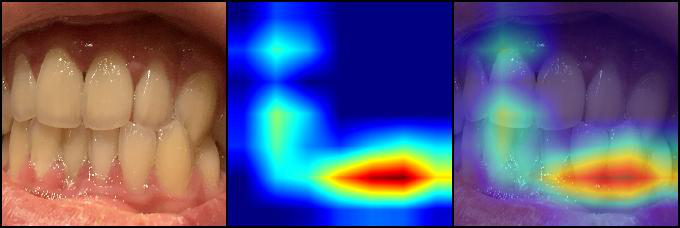

In [13]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = 'custom_1.jpg'
output_path = os.path.join(output_dir, output_name)
save_image(images, output_path)
PIL.Image.open(output_path)